# Загрузка Pandas и очистка данных

In [814]:
import pandas as pd
import ast
from bs4 import BeautifulSoup
import requests
import numpy as np
from multiprocessing import  Pool
from datetime import datetime, timedelta
from collections import namedtuple
# this is just a file with a worker function for multiprocessing
# (otherwise multiprocessing doesn't work in Jupyter on Windows)
import worker  
import random
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

In [815]:
df = pd.read_csv('main_task.xls')
df_small = df.iloc[:20,:]
#df_small
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [816]:
# Helper functions are defined in this cell

def drop_by_type(d, t):
    '''
    Drops columns of the dataframe based on their type
    Params:
        d - target dataframe
        t - type (from types returned by dtype) 
            provided as text (for example, 'float64')
    '''
    df_temp = d.copy()
    to_drop = [c for c in d.columns if t == str(d[c].dtype)]
    df_temp.drop(to_drop, axis=1, inplace=True)
    print(f"List of dropped columns (by type {t}): {to_drop}")
    return df_temp

'''
# These functions are in worker.py file now
def from_website(url):
    #print(f"https://www.tripadvisor.com{url}")
    r = requests.get(f"https://www.tripadvisor.com{url}", timeout=2)
    soup = BeautifulSoup(r.content)
    
    tmp = soup.find_all('span', {"class":"ratingDate"})
    rev_dates_lst = [i['title'] for i in tmp]
    #rev_dates_lst = [datetime.strptime(i['title'], '%B %d, %Y') for i in tmp]
    
    return rev_dates_lst


def apply_to_dataframe(df):
    df_result = df.copy()
    df_result['all_review_dates'] = df_result['URL_TA'].apply(from_website)
    return df_result
'''

def parallelize_dataframe(df, func, n_cores=12):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df


def create_freq_dict(d):
    '''
    Input dictionary must be sorted!
    
    This function takes dictionary with absolute frequencies as an argument
    and converts it into dictionary with relative frequencies percentages.
    
    For example, dictionary {'$$$$': 1423, '$': 6279, '$$ - $$$': 18412}
    will be turned into {'$$$$': 5.0, '$': 24.0, '$$ - $$$': 71.0}
    '''
    result = d
    tot = np.sum(list(d.values()))
    for k, v in d.items():
        d[k] = round(int(v) / tot * 100,0)
    
    return result


def fill_na_by_frequency(freq_dict, col):
    '''
    This function is used to replace NaN for categorical
    columns with values based on the frequency of non-missing values.

    For this function to work freq_dict (frequency dictionary) should be passed
    as an arguemnt. That's how frequency dictionary might look like (just an example)
    freq_dict: {'other': 7.0, 'father': 24.0, 'mother': 69.0}.
    Numbers correspond to the frequency of every possible distinct value.

    IMPORTANT: this function can't be applied using df.fillna() because the result
    must be different for every row it applies to, whereas fillna() replaces all NaN
    with a single value. Therefore apply() should be used on a column (series)
    '''

    random.seed(10)
    rnd_check = round(random.random()*100)    
    
    cumulative = 0
    for k, v in freq_dict.items():
        # cumulative is used to correctly assess the probability
        # for example, if we take {'other': 7.0, 'father': 24.0, 'mother': 69.0}
        # then "other" will be picked is rnd_check if <= 7, "father" will be
        # picked if rnd_check <= 31 and "mother" will be picked in al the other cases
        cumulative += v
        if rnd_check <= cumulative:
            #print(f'Random number is: {rnd_check}. Value is: {k}')
            return k
    # the last option
    return k
    #print(f'Random number is: {rnd_check}. Value is: {k}')
    
    
def convert_price_range(s):
    '''
    Converts price ranges provided as one of these values
    $
    $$ - $$$            
    $$$$
    to low, average and high 
    '''
    if s == '$':
        return 'low'
    elif s == '$$ - $$$':
        return 'average'
    elif s == '$$$$':
        return 'high'
    else:
        return 'other'

def median_interval(l):
    '''
    Takes a list with dates as strings in a format like 'February 28, 2017'
    and returns a median interval between 2 consequent dates in a dataset
    '''   
    tmp = ast.literal_eval(l)
    res_lst = []
    if len(tmp) > 1:
        tmp = [datetime.strptime(i, '%B %d, %Y') for i in tmp]
        i = 0
        for d in tmp:
            res_lst.append((tmp[i] - d).days)
        return np.median(res_lst)
    return -1

def restaurant_age(l):
    '''
    Takes a list with dates as strings in a format like 'February 28, 2017'
    and returns a day difference between now and the first review date
    (let's  consider that an estimate of restaurant age)
    '''   
    tmp = ast.literal_eval(l)
    res_lst = []
    if len(tmp) > 0:
        tmp = [datetime.strptime(i, '%B %d, %Y') for i in tmp]
        return (datetime.now() - np.min(tmp)).days
    return -1

# def avg_comment_length(l):
#     '''
#     Takes a list of comments and returns an average length of a comment
#     '''
#     tmp = l
#     tmp.replace('[', '')
#     tmp.replace(']', '')
#     if len(tmp) > 0:
#         tmp = [len(i) for i in tmp]
#         return np.mean(tmp)
#     return -1

In [817]:
''' 
# Uncomment it only if you need to crawl Tripadvisor website once again
if __name__ ==  '__main__': 
    df_crawled = parallelize_dataframe(df, worker.apply_to_dataframe)
    
df_crawled.to_csv('with_additional_data_fromTA_proper_dates.csv')    
'''

# this is a file that consists of an original dataframe 
# extended with additional data from Tripadvisor website
# using requests and beautifulsoup
df = pd.read_csv('with_additional_data_fromTA_proper_dates.csv')
df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
df.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,all_review_dates
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"['February 14, 2020', 'December 20, 2019', 'No..."
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"['February 27, 2020', 'July 6, 2017', 'June 19..."
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,"['September 25, 2020', 'September 5, 2020', 'A..."
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,"['February 19, 2016', 'May 4, 2012', 'April 26..."
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,"['September 10, 2020', 'September 28, 2019', '..."


In [818]:
# determining unique cuisine styles and their value counts
# ast.literal_eval is required because lists of styles are
# represented as strings in the dataframe
# IMPORTANT: nan values are replaced by the fake list "['dummy_style']"
df['cuisine_styles_num'] = df['Cuisine Style'].fillna("['dummy_style']").apply(ast.literal_eval).apply(len)
df.drop(labels=['Cuisine Style'], axis=1, inplace=True)
df.head()

,Restaurant_id,City,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,all_review_dates,cuisine_styles_num
0,id_5569,Paris,5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,"['February 14, 2020', 'December 20, 2019', 'No...",3
1,id_1535,Stockholm,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,"['February 27, 2020', 'July 6, 2017', 'June 19...",1
2,id_352,London,353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,"['September 25, 2020', 'September 5, 2020', 'A...",7
3,id_3456,Berlin,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,"['February 19, 2016', 'May 4, 2012', 'April 26...",1
4,id_615,Munich,621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,"['September 10, 2020', 'September 28, 2019', '...",3


In [819]:
# let's consider NaN in number of reviews as 0
df['Number of Reviews'].fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Restaurant_id       40000 non-null  object 
 1   City                40000 non-null  object 
 2   Ranking             40000 non-null  float64
 3   Rating              40000 non-null  float64
 4   Price Range         26114 non-null  object 
 5   Number of Reviews   40000 non-null  float64
 6   Reviews             40000 non-null  object 
 7   URL_TA              40000 non-null  object 
 8   ID_TA               40000 non-null  object 
 9   all_review_dates    40000 non-null  object 
 10  cuisine_styles_num  40000 non-null  int64  
dtypes: float64(3), int64(1), object(7)
memory usage: 3.4+ MB


In [820]:
df['City'].nunique()

31

In [821]:
# There are too many unique cities in the dataset (31) - therefore one hot encoding is not an option.
# Let's use worldcities dataset from https://www.kaggle.com/viswanathanc/world-cities-datasets
# I want to create 2 dimension from an original 'City' column: capital and  population
df_cities = pd.read_csv('worldcities.csv')

# leaving only required columns from worldcities data set
df_cities = df_cities[['city_ascii','capital','population']]

# the assumption here is that most of the capitals will be listed as primary
# and we don't really care about other classification because the variable will be
# binary in the end (capital = 0 or 1)
df_cities['capital'].fillna('other', inplace=True) 

# the assumption here is that most important cities will have the population
# mentioned in the data set
df_cities['population'].fillna(0, inplace=True)

# leaving only cities with max population - this will eliminate duplicates
# in case multiple cities with the same name exist
df_cities.sort_values(by=['city_ascii','population'], ascending=[True,False], inplace=True)
df_cities.drop_duplicates(subset='city_ascii', keep='first', inplace=True)

# making sure we have no more duplicates
df_cities['city_ascii'].value_counts()

Inhambane           1
D'Iberville         1
Malibu              1
Nordhragota         1
Camrose             1
                   ..
Xuddur              1
Summerfield         1
La Asuncion         1
Prospect Heights    1
Vadodara            1
Name: city_ascii, Length: 13482, dtype: int64

In [822]:
# modifying 'capital' column to make it binary (if capital then 1 else 0)
df_cities['capital'] = df_cities['capital'].map(lambda x : 1 if x == 'primary' else 0)
df_cities['capital'].value_counts()

0    13275
1      207
Name: capital, dtype: int64

In [823]:
# merging df with df_cities based on city name
df = df.merge(df_cities, how='left', left_on='City', right_on='city_ascii')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Restaurant_id       40000 non-null  object 
 1   City                40000 non-null  object 
 2   Ranking             40000 non-null  float64
 3   Rating              40000 non-null  float64
 4   Price Range         26114 non-null  object 
 5   Number of Reviews   40000 non-null  float64
 6   Reviews             40000 non-null  object 
 7   URL_TA              40000 non-null  object 
 8   ID_TA               40000 non-null  object 
 9   all_review_dates    40000 non-null  object 
 10  cuisine_styles_num  40000 non-null  int64  
 11  city_ascii          39487 non-null  object 
 12  capital             39487 non-null  float64
 13  population          39487 non-null  float64
dtypes: float64(5), int64(1), object(8)
memory usage: 4.6+ MB


In [824]:
# let's see what cities are missing
df[df['capital'].isna()]['City'].value_counts()

Oporto    513
Name: City, dtype: int64

In [825]:
# it seems that we're missing the data about only one city - Oporto (aka Porto in Portugal)
# let's locate it and populate missing values manually
df['capital'].fillna(0, inplace=True)
df['population'].fillna(1337000, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ranking             40000 non-null  float64
 1   Rating              40000 non-null  float64
 2   Price Range         26114 non-null  object 
 3   Number of Reviews   40000 non-null  float64
 4   all_review_dates    40000 non-null  object 
 5   cuisine_styles_num  40000 non-null  int64  
 6   capital             40000 non-null  float64
 7   population          40000 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.7+ MB


In [ ]:
# let's drop some columns that are not required anymore
# to make the dataframe more compact and readable
df.drop(['Restaurant_id','Reviews','URL_TA', 'ID_TA', 'city_ascii', 'City'], axis=1, inplace=True)
df.info()

In [826]:
# let's take a look at price ranges
df['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [827]:
# it seems there are many NaN values among price ranges
# let's replace NaN with values based on a frequency of the existing values
# custom function will be used for that (see definition of helper functions above)

# please note that ascending=True is important here because the dictionary must be sorted
freq_dict = create_freq_dict(dict(df['Price Range'].value_counts(ascending=True)))
df['Price Range'] = df['Price Range'].apply(
    lambda x: fill_na_by_frequency(freq_dict, "Price Range") if pd.isna(x) else x)
# also let's make Price Range names more meaningful
df['Price Range'] = df['Price Range'].apply(convert_price_range)

In [828]:
# let's take a look at price ranges once again - it seems that there are
# no more missing values
df['Price Range'].value_counts()

average    32298
low         6279
high        1423
Name: Price Range, dtype: int64

In [829]:
# and there are no more missing values in the dataframe as such
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Ranking             40000 non-null  float64
 1   Rating              40000 non-null  float64
 2   Price Range         40000 non-null  object 
 3   Number of Reviews   40000 non-null  float64
 4   all_review_dates    40000 non-null  object 
 5   cuisine_styles_num  40000 non-null  int64  
 6   capital             40000 non-null  float64
 7   population          40000 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.7+ MB


In [830]:
# processing Price Range with one hot encoder
enc = OneHotEncoder(handle_unknown='ignore')
y = OneHotEncoder().fit_transform(df['Price Range'].to_numpy().reshape(-1, 1)).toarray()
df_price_rng = pd.DataFrame(y, columns=['average','high','low'])
df = pd.concat([df,df_price_rng], axis=1)
df.drop(['Price Range'], inplace=True, axis=1)
# df.head(20)

In [831]:
# let's calculate median interval between consequetive review dates
# for every restaraunt and drop 'all_review_dates' column
#df['median_days_between_reviews'] = df['all_review_dates'].apply(median_interval)
df['restaurant_age'] = df['all_review_dates'].apply(restaurant_age)
df.drop(labels=['all_review_dates'], axis=1, inplace=True)
df.head()

,Ranking,Rating,Number of Reviews,cuisine_styles_num,capital,population,average,high,low,restaurant_age
0,5570.0,3.5,194.0,3,1.0,9904000.0,1.0,0.0,0.0,454
1,1537.0,4.0,10.0,1,1.0,1264000.0,1.0,0.0,0.0,1741
2,353.0,4.5,688.0,7,1.0,8567000.0,0.0,1.0,0.0,223
3,3458.0,5.0,3.0,1,1.0,3406000.0,1.0,0.0,0.0,3081
4,621.0,4.0,84.0,3,0.0,1275000.0,1.0,0.0,0.0,886


In [832]:
# experimenting with deropping different columns
#df.drop(['high'], inplace=True, axis=1)
df.drop(['low'], inplace=True, axis=1)
# df.drop(['average'], inplace=True, axis=1)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [833]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
#X = df.drop(['Restaurant_id', 'Rating'], axis = 1)
X = df.drop(['Rating'], axis = 1)
y = df['Rating']

In [834]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [835]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [836]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [837]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [838]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21182999999999996


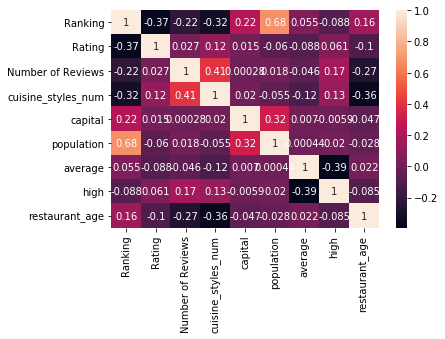

In [839]:
sns.heatmap(df.corr(), annot=True)